# **Import Librarys**

In [13]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from transformers import DataCollatorWithPadding
from datasets import Dataset

# **Tokenizer dan Dataset Format (untuk HuggingFace Trainer)**

In [9]:
# Load tokenizer
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load data yang telah diproses
train_df = pd.read_csv('../data/split_data_full/train_dataset.csv')
val_df = pd.read_csv('../data/split_data_full/val_dataset.csv')
test_df = pd.read_csv('../data/split_data_full/test_dataset.csv')

# Konversi Pandas DataFrame ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Fungsi tokenisasi
def tokenize_function(examples):
    return tokenizer(examples['stemming'], truncation=True, max_length=256)

# Tokenisasi dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/11833 [00:00<?, ? examples/s]

Map:   0%|          | 0/1690 [00:00<?, ? examples/s]

Map:   0%|          | 0/3382 [00:00<?, ? examples/s]

# **Set format dataset ke format PyTorch**

In [10]:
train_dataset = train_dataset.rename_column("label_num", "labels")
val_dataset = val_dataset.rename_column("label_num", "labels")
test_dataset = test_dataset.rename_column("label_num", "labels")

# Pastikan hanya ambil kolom input_ids, attention_mask, dan labels
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# **Model Setup**

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="../training_args",
    eval_strategy="epoch",  # Evaluasi dilakukan di akhir setiap epoch
    save_strategy="epoch",  # Simpan model di akhir setiap epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=3  # Simpan hanya 3 model terbaik
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Define metric evaluasi**

In [32]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        "f1": f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    }


# **Trainer Setup**

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# **Fine-tuning IndoBERT**

In [19]:
# untuk mempercepat training
%pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Mulai mencatat waktu
start_time = time.time()

# Melatih model
trainer.train()

# Selesai mencatat waktu
end_time = time.time()

# Menghitung durasi
training_duration = end_time - start_time

# Tampilkan durasi dalam format jam:menit:detik
import datetime
formatted_duration = str(datetime.timedelta(seconds=int(training_duration)))
print(f"Durasi pelatihan: {formatted_duration}")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.384400,0.435470,0.816568,0.733937
2,0.297700,0.447883,0.837870,0.758938
3,0.190900,0.633356,0.830178,0.763120
4,0.019000,0.821652,0.840237,0.775597


Durasi pelatihan: 0:24:09


# **Evaluasi Model**

In [34]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.8403234481811523, 'eval_model_preparation_time': 0.006, 'eval_accuracy': 0.8358959195742165, 'eval_f1': 0.771293626247569, 'eval_runtime': 31.2869, 'eval_samples_per_second': 108.096, 'eval_steps_per_second': 6.776}


# **save model**

In [38]:
# Simpan model dan tokenizer
trainer.save_model("../models/indoBERT_finetuning_full")


# **test model**

In [40]:
preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(-1)

In [41]:
# Classification report
target_names = ['positif', 'netral', 'negatif']
print(classification_report(test_dataset["labels"], pred_labels, target_names=target_names))

              precision    recall  f1-score   support

     positif       0.60      0.67      0.63       229
      netral       0.82      0.77      0.80      1182
     negatif       0.87      0.89      0.88      1971

    accuracy                           0.84      3382
   macro avg       0.77      0.78      0.77      3382
weighted avg       0.84      0.84      0.84      3382



## _**Visualisasi Model**_

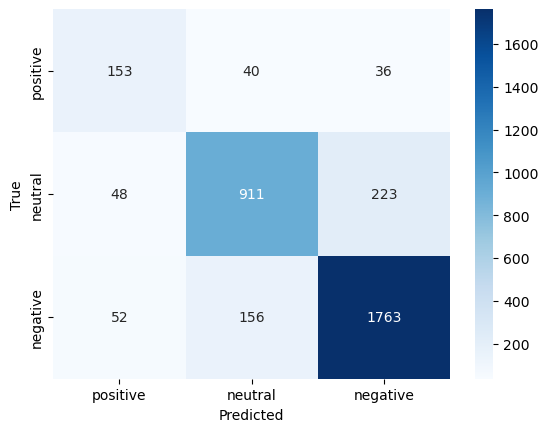

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_dataset['labels'], pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
def predict_sentiment_debug(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available
    model.to(device)  # Move model to the appropriate device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Move inputs to the same device
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=-1)  # Hitung probabilitas
    label_map = {0: "positive", 1: "neutral", 2: "negative"}  # Mapping label
    for i, prob in enumerate(probs[0]):
        print(f"{label_map[i]}: {prob.item() * 100:.3f}%")
    predicted_class = torch.argmax(probs, dim=-1).item()  # Ambil label prediksi
    confidence = probs[0][predicted_class].item() * 100  # Ambil probabilitas prediksi
    return label_map[predicted_class], confidence

# Contoh teks untuk prediksi
text = "cantik sekali"
label, confidence = predict_sentiment_debug(text)

# Output hasil prediksi
print(f"Text: {text} | Label: {label} ({confidence:.3f}%)")

positive: 99.775%
neutral: 0.023%
negative: 0.202%
Text: cantik sekali | Label: positive (99.775%)
